In [ ]:
#TODO: aggiungere commenti
    # ricreare tabelle con indicazione di precision
# TODO: testare tutto, sistemare in ambiente distribuito

# ML algorithm for pattern classification
This notebook contains the definitions and training pipeline of the machine learning algorithms applied in the paper.
For each algorithm, a model will be created with the same hyperparameters as the ones declared in the paper (defaults hyperparameters of <code>sklearn</code>).

Said model will be trained and tested on the split already provided from the beginning of the SeqScout procedure. In this way, we can have a score that is as much as comparable as possible with the values reported by the paper.


Then, an hyperparameter search will be conducted on the models via cross validation on the training split. The best performing model will be again trained on the full train set and tested on test set, in order to compare it to the default model.
Each model will be compared on accuracy, precision and recall. Moreover, the confusion matrix for each best performing model will be produced.

## Major differences
Aside from the machine learning library employed, the presented algorithms differ from the original paper in a couple of aspects:
- They use the OneVsRest classifier for each model, while we use directly the multiclass classifier (except for the LinearSVC). This allows to save time on the model training and consequently on the hyperparameter search.
- The results will be computed on a single test split equal to a fifth of the original dataset. This split follows the same split employed for k-fold evaluation in the original paper. This choice was made considering the high overhead required when computing the patterns.
- As SVM model, pyspark has only the LinearSVC implemented, thus it will be used in place of SVC. In this case, the default parameter considered for the baseline model will be the ones provided by pyspark.

## Imports and library installation
As the default package of PySpark does not include the algorithm for the XGBoost, a cell to install the appropriate libraries is added

In [3]:
!pip install scikit-learn
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 7.0 MB/s eta 0:00:0000:0100:01


In [1]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC, OneVsRest, NaiveBayes
from pyspark.ml.classification import DecisionTreeClassificationModel, RandomForestClassificationModel, OneVsRestModel, NaiveBayesModel
from pyspark.mllib.tree import RandomForestModel, DecisionTreeModel
from pyspark.ml.tuning import CrossValidatorModel
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from utils import load_df
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.stat import Summarizer

## Dataset loading, function definitions and brief preliminary analysis
As first step, we load the already encoded dataframes for training and testing the algorithms. We also set the path where the models will be saved as well as the random seed for reproducibility.

In [5]:
spark = SparkSession.builder.appName("RocketLeagueL").getOrCreate()

#base_path = 'hdfs://hdmaster:9000/user/ubuntu/dataset/'
base_path ='./'
path = base_path + "dataset/"

modelpath = base_path + 'models/'
train = load_df(path, "encoded_df", spark)
test = load_df(path, "encoded_test", spark)
seed = 42


Cells for the loading of checkpoints of the trained models are then added

In [7]:
# loads base models
print("Loading decision tree...")
dtcf = DecisionTreeClassificationModel.load(modelpath + 'decision_tree/base')
print("Loading random forest...")
rfcf = RandomForestClassificationModel.load(modelpath + 'random_forest/base')
print("Loading XGBoost...")
xgbf = SparkXGBClassifierModel.load(modelpath + 'xgb/base')
print("Loading SVM...")
svmf = OneVsRestModel.load(modelpath + 'svm/base')
print("Loading Naive Bayes...")
nbf = NaiveBayesModel.load(modelpath + 'nb/base')

Loading decision tree...


Loading random forest...


Loading XGBoost...
Loading SVM...
Loading Naive Bayes...


In [8]:
# loads tuned models (takes some time)
print("Loading tuned decision tree...")
dtc_cv_model = CrossValidatorModel.load(modelpath + 'decision_tree/hyperParameterTuned')
print("Loading tuned random forest...")
rfc_cv_model = CrossValidatorModel.load(modelpath + 'random_forest/hyperParameterTuned')
print("Loading tuned XGBoost...")
xgb_cv_model = CrossValidatorModel.load(modelpath + 'xgb/hyperParameterTuned2')
print("Loading tuned SVM...")
svm_cv_model = CrossValidatorModel.load(modelpath + 'svm/hyperParameterTuned')
print("Loading tuned Naive Bayes...")
nb_cv_model = CrossValidatorModel.load(modelpath + 'nb/hyperParameterTuned')

Loading tuned decision tree...
Loading tuned random forest...


Loading tuned XGBoost...
Loading tuned SVM...
Loading tuned Naive Bayes...


Then, a couple of function are defined in order to automatically compute the evaluation metrics and to print them together with the confusion matrix. Moreover, to improve the readability of the produced graph, the list of labels for the classes is also added.

In [38]:
ordered_labels = ['Noise', 
                      'Ceiling Shot', 
                      'Power Shot', 
                      'Waving Dash',
                      'Air Dribbling',
                      'Front Flick',
                      'Musty Flick']

def compute_metrics(prediction_df):
    """
    Function computing some metrics for the evaluation of the machine learning models. It uses MulticlassMetrics from
    the pyspark library.
    params:
        prediction_df: pyspark dataframe containing at least a prediction column called "prediction"
                       amd a class colimn called "class"
    returns:
        a MulticlassMetrics object containing the metrics about the prediction_df
    """
    rdd_pred = prediction_df.select("prediction", "class").withColumn("class",F.col('class').cast(FloatType())).orderBy('class').rdd.map(tuple)
    metrics = MulticlassMetrics(rdd_pred)
    return metrics

def print_metrics(prediction_df, ordered_labels=ordered_labels):
    """
    Function printing some metrics for evaluation, as well as the confusion matrix given a pyspark dataframe
    with ground truth labels and predictions. The confusion matrix is printed with values normalized on the true and false
    positives (precision)
    params:
        prediction_df: pyspark dataframe containing at least a prediction column
                       called "prediction" and a class column called "class"
        ordered_labels: list of labels whose position order corresponds to the position order of the corresponding class values
    """
    metrics = compute_metrics(prediction_df)
    print("Accuracy: ")
    print(f'%.3f'%metrics.accuracy)
    print("Weighted precision: ")
    print(f'%.3f'%metrics.weightedPrecision)
    print("Weighted recall: ")
    print(f'%.3f'%metrics.weightedRecall)
    cm = metrics.confusionMatrix().toArray()
    cm = cm / (cm.sum(axis=0))

    sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    

### Classes distribution
In the following barplots we verify again that the class distribution is equal between the training and the test split, as a stratified one was performed during the pre-processing procedure. The only classes that are slightly skewed in the test set w.r.t. the trianing one are the "Air Dribbling" and "Front Flick" classes.

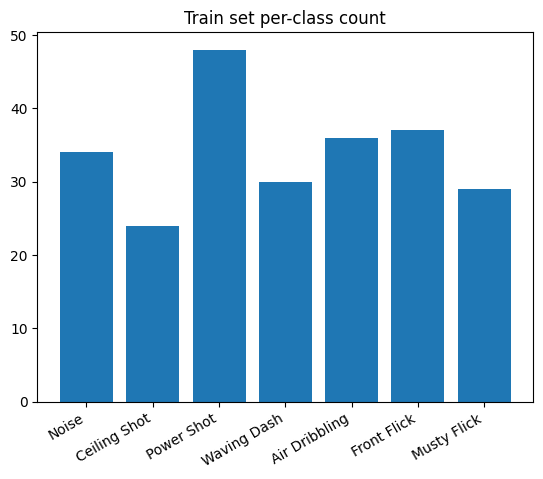

In [87]:
# getting per class counts
hist_data_train = train.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Train set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_train], tick_label=ordered_labels)
plt.show()

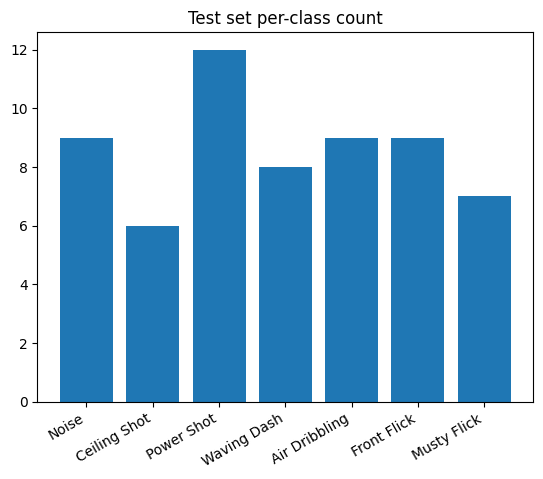

In [86]:
hist_data_test = test.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Test set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_test], tick_label=ordered_labels)
plt.show()

### Features distribution
Then, since at this point the dataset is mainly constituted of binary features indicating whether a specific pattern has been found in a sequence, we can see how these pattern effectively encode the charateristics of a class. 

In order to do so, we group the DataFrame by class, sum over the values of the binary features, normalize this values by column and then show the results as a heatmap. 

We should expect the heatmap to show the "main diagonal" to have higher values (shown with brighter colors) and since the features were added by following the order induced by the values used to indicate the classes (e.g. first 20 features/patterns refers to the "Ceiling Shot" (class 1), the following 20 refers to "Power Shot" (class 2), etc.)

In [78]:
def show_heatmap(dataframe, c="class", feats="features", ordered_labels=ordered_labels):
    """
    Function printing the heatmap of a given binary dataframe. In particular, the function groups the rows by the column
    c, sums the values in feats and then turns them into percentage.
    params:
        dataframe: input dataframe containing the information to be aggregated
        c: column name to be used to group the records
        feats: name of the column to be aggregated
        ordered_labels: list of ordered names to be given to the rows of the heatmap
    """
    summarized_df = dataframe.groupBy(c).agg(Summarizer.sum(F.col(feats)).alias("per_c_sum")).orderBy(c)\
                    .select("per_c_sum")
    norm = summarized_df.agg(Summarizer.sum(summarized_df.per_c_sum).alias("norm")).collect()[0].asDict()["norm"] 
    if norm.numNonzeros() != len(norm):
        norm = norm.toArray()
        norm[norm == 0.] = 1
    summarized_df = summarized_df.collect()
    summarized_df = [summarized_df[i].asDict()["per_c_sum"]/norm for i in range(len(summarized_df))]
    fig, ax = plt.subplots(figsize=(25,3)) 
    sns.heatmap(summarized_df, yticklabels=ordered_labels, ax=ax)
    plt.xlabel("features")
    plt.show()

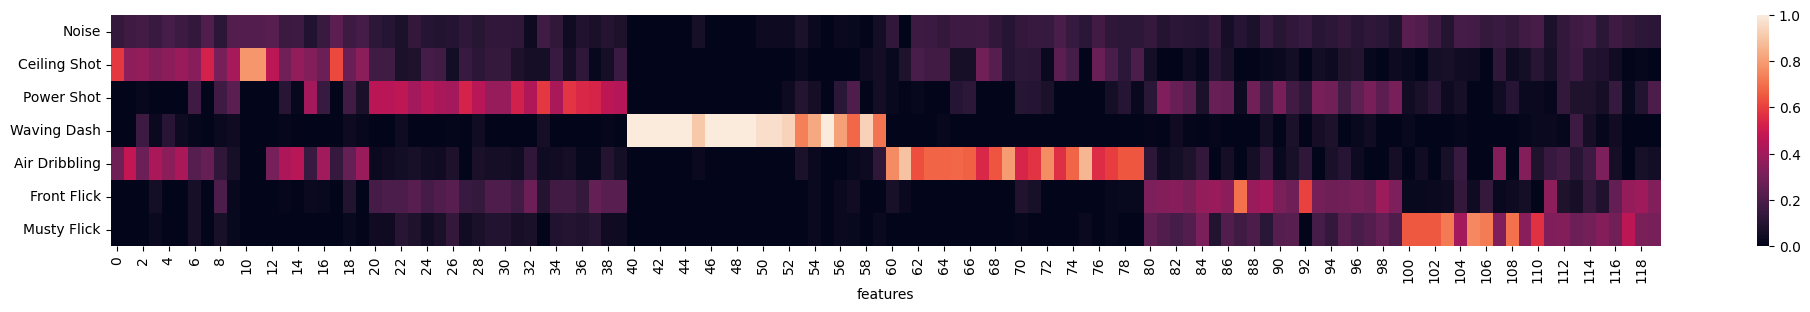

In [79]:
show_heatmap(train)

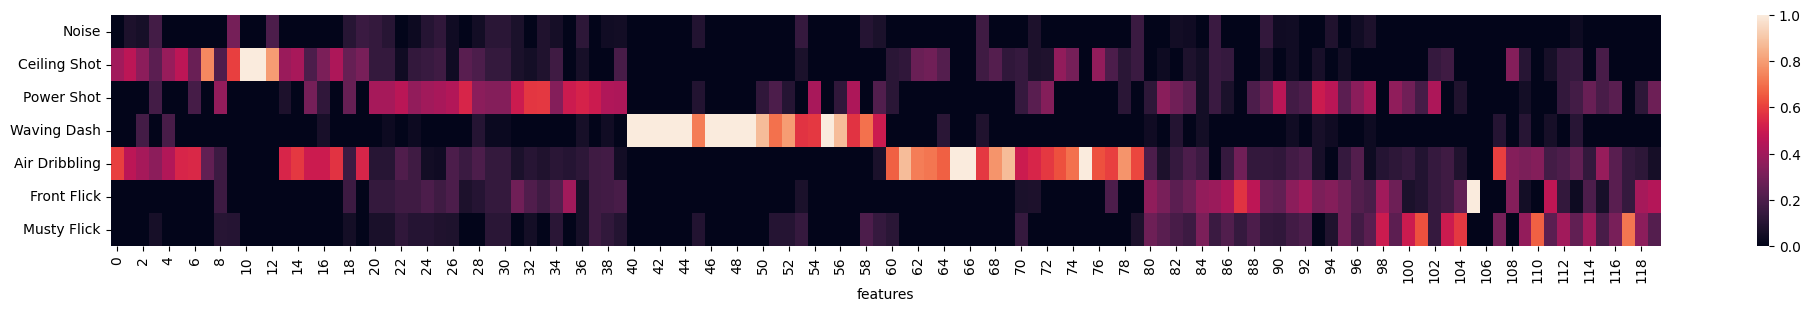

In [80]:
show_heatmap(test)

The general trend follows what we were expecting, having brighter colors on the main diagonal. Said diagonal is "sharper" on the training set w.r.t to the test split as the patterns were extracted directly from that part of the dataset. 

We can also observe that the first row, referring to the noise sequences, incorporates most of the patterns but never in a distinctive way.

Finally we can also observe that some patterns can consistently encode also shots for which do not belong to the same class for which they were extracted for:
- Patterns for "Ceiling shot" found in "Air Dribbling" (and viceversa);
- Patterns for "Power shot" found in "Front Flick" (and viceversa);
- Patterns for "Front flick" found in "Musty Flick" (and viceversa, even if less prominent).

This can be explained considering that said pairs of shots have similar setups and/or are similar in nature. With the same background knowledge on the game, we can explain why the patterns for the "Waving Dash" pattern are more clearly defined. In fact, differently from the other tricks, its the only one that is purely used for movement rather than scoring a point.

In conclusion, even if the analysis is somewhat reductive as it doesn't take into account the correlations between the patterns, it will be still useful to help analyzing the results of the models.

# Machine Learning models training and tuning
As previously said, we start by creating a base model which will also serve as comparison.
Then we proceed to apply a grid search with a 4-fold cross validation to find the best set of hyperparameters for the models.
The models are automatically re-trained on the full training at the end of the CV procedure.

## Decision Tree


In [8]:
dtc = DecisionTreeClassifier(maxDepth=30, seed=seed, featuresCol='features', labelCol='class')
# apparently 30 is the currently supported maximum depth for pyspark

# fitting the model
dtcf = dtc.fit(train)
# saving
dtcf.save(modelpath + 'decision_tree/base')

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       0.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.733
Weighted precision: 
0.823
Weighted recall: 
0.733


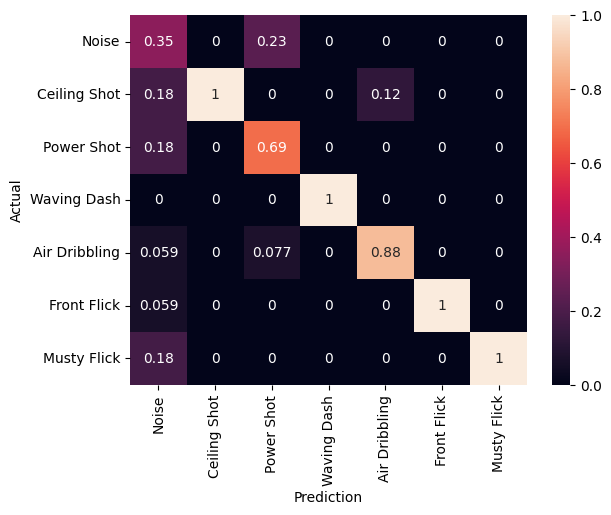

In [44]:
# getting predictions
dtc_predictions = dtcf.transform(test)
dtc_predictions.select("prediction", "class").show(15)
print_metrics(dtc_predictions)

In the case of the Decision tree we optimize w.r.t the following hyperparameters:
- Impurity criterion: Gini index or entropy;
- Maximum depth of the tree: between 3 and 15. Since the features are binary, 3 is chosen as it allows to create a tree with at least 8 different labeled leaf nodes, which is slightly above the number of classes (7);
- Minimum instances in a leaf node: between 1 to 5;
- Minimum gain in the impurity criterion to apply the split: in [0.1, 1] with steps of 0.1.

In [65]:
# base model
dtc_cv = DecisionTreeClassifier(featuresCol='features', labelCol='class',seed=seed)
# creating the grid
dtc_param_grid = ParamGridBuilder()\
                .addGrid(dtc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(dtc_cv.maxDepth, [i+1 for i in range(3,15)])\
                .addGrid(dtc_cv.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(dtc_cv.minInfoGain, [0.1*i for i in range(11)]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

dtc_cross_val = CrossValidator(estimator=dtc_cv,
                              estimatorParamMaps=dtc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [7]:
# fitting and tuning
dtc_cv_model = dtc_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [45]:
print("Best parameters:")
print({k.name : v for (k,v) in dtc_cv_model.getEstimatorParamMaps()[np.argmax(dtc_cv_model.avgMetrics)].items()})
dtc_cv_model.save(model_path+"decision_tree/hyperParameterTuned")

Best parameters:
{'minInfoGain': 0.2, 'minInstancesPerNode': 2, 'impurity': 'entropy', 'maxDepth': 7}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.800
Weighted precision: 
0.846
Weighted recall: 
0.800


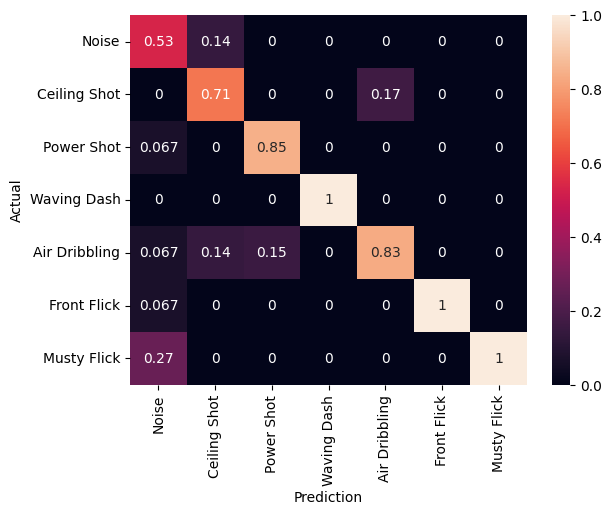

In [45]:
dtc_best_pred = dtc_cv_model.transform(test)
dtc_best_pred.select("prediction", 'class').show(15)
print_metrics(dtc_best_pred)

# COMMENTI SUI RISULTATI

## Random Forest

In [ ]:
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='class',
                             featureSubsetStrategy='sqrt',
                             maxDepth=30,
                             numTrees=100,
                             seed=seed)
#fitting the model
rfcf = rfc.fit(train)
# saving
rfcf.save(model_path+"models/random_forest/base")

23/09/27 23:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1381.0 KiB
+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

23/09/27 23:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
23/09/27 23:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
23/09/27 23:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1392.9 KiB
Accuracy: 
23/09/27 23:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
0.850
Weighted precision: 
0.874
Weighted recall: 
0.850


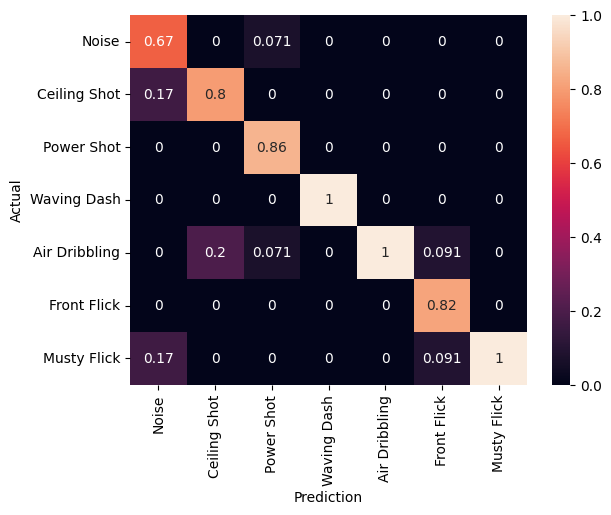

In [47]:
# getting predictions
rfc_predictions = rfcf.transform(test)
rfc_predictions.select('class', 'prediction').show(15)
print_metrics(rfc_predictions)

For the Random forest we build the grid on the following parameters:
- Impurity measure: Gini index or entropy;
- Maximum depth of the trees: between 3 and 10. The range is reduced w.r.t. the decision tree after checking that the best <code>max_depth</code> for the tree is 7;
- Minimum instances in a leaf node: between 1 and 3. Also here the range is reduced as above;
- Minimum information gain for the split: in {0.2, 0.4, 0.6, 0.8, 1};
- Strategy for the selection of features when building a new tree: between all the available ones - all, one third of the total, square root of the total, base 2 logarithm of the total;
- Number of trees in the forest: in {25, 50, 75, 100, 125, 150, 175, 200};
- Subsampling percentage to be applied on the dataset when building a tree: in {0.2, 0.4, 0.6, 0.8, 1}

In [12]:
# base model
rfc_cv = RandomForestClassifier(featuresCol='features', labelCol='class',seed=seed)

# in hyperparameters optimization we are considering only the automatic feature selection methods
rfc_param_grid = ParamGridBuilder()\
                .addGrid(rfc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(rfc_cv.maxDepth, [i+1 for i in range(3,10)])\
                .addGrid(rfc_cv.minInstancesPerNode, [i+1 for i in range(3)])\
                .addGrid(rfc_cv.minInfoGain, [0.2*i for i in range(1,6)])\
                .addGrid(rfc_cv.featureSubsetStrategy, ['sqrt', 'all', 'log2', 'onethird'])\
                .addGrid(rfc_cv.numTrees, [25*i for i in range(1,9)])\
                .addGrid(rfc_cv.subsamplingRate, [0.2*i for i in range(1, 6)]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')


rfc_cross_val = CrossValidator(estimator=rfc_cv,
                              estimatorParamMaps=rfc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
# fitting and tuning
rfc_cv_model = rfc_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [46]:
print("Best parameters:")
print({k.name : v for (k,v) in rfc_cv_model.getEstimatorParamMaps()[np.argmax(rfc_cv_model.avgMetrics)].items()})
rfc_cv_model.save(model_path+"random_forest/hyperParameterTuned")

Best parameters:
{'featureSubsetStrategy': 'onethird', 'numTrees': 25, 'maxDepth': 7, 'impurity': 'entropy', 'minInfoGain': 0.2, 'minInstancesPerNode': 1, 'subsamplingRate': 0.8}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.883
Weighted precision: 
0.897
Weighted recall: 
0.883


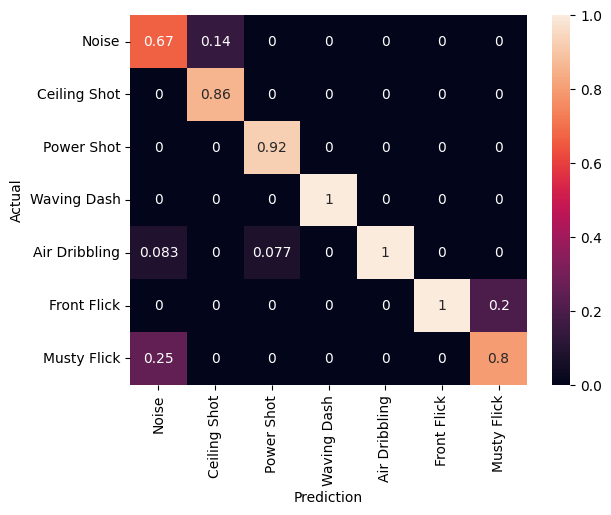

In [48]:
rfc_best_pred = rfc_cv_model.transform(test)
rfc_best_pred.select("prediction", 'class').show(15)
print_metrics(rfc_best_pred)

# COMMENTO RISULTATI

## XGBoost

In [17]:
xgb = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         random_state=seed)
# fitting the model
xgbf = xgb.fit(train)
# saving the model
xgbf.save(model_path+'xgb/base')

2023-09-17 20:56:02,491 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_depth': 7, 'random_state': 42, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[20:56:03] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-17 20:56:04,981 INFO XGBoost-PySpark: _fit Finished xgboost training!   


2023-09-27 23:55:20,273 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows



2023-09-27 23:55:21,448 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-27 23:55:21,568 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


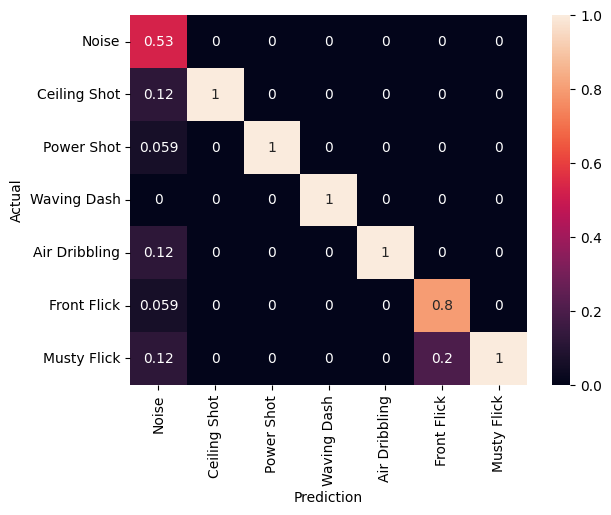

In [49]:
# getting the results
xgb_predictions = xgbf.transform(test)
xgb_predictions.select('class', 'prediction').show(15)
print_metrics(xgb_predictions)

Due to the large hyperparameter space of XGBoost, the search was intially focused on the more important parameters to be tuned.
The values were chosen based on previous results on the Decision Tree (<code>max_depth</code>) or considering this [article](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) as a reference. Also the set of hyperparameters is restricted due to the overhead required for training.
The tuned parameters are:
- Learning rate: in {0.01, 0.1, 0.3};
- Maximum depth of the tree: in {5, 6, 7, 8, 9};
- Lambda regularization term (L2): in {0, 0.1, 0.5, 1};
- Alpha regularization term (L1): in {0, 0.1, 0.5, 1};
- Feature sample rate to be applied at each boosting round: in {0.5, 0.75, 1};
- Number of boosting rounds: in {50, 100, 200}.

Other parameters were also tested (as <code>colsample_bynode</code>, <code>colsample_by_level</code>, <code>subsample</code>, DART booster...) but they are not presented as they didn't improve the performances of the model.

In [24]:
# base model
xgb_cv = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed)
# building the grid
xgb_param_grid = ParamGridBuilder()\
                .baseOn({xgb_cv.verbose:0})\
                .addGrid(xgb_cv.learning_rate, [0.01, 0.1, 0.3])\
                .addGrid(xgb_cv.max_depth, [i for i in range(5,9)])\
                .addGrid(xgb_cv.reg_lambda, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.reg_alpha, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.colsample_bytree, [0.5, 0.75, 1])\
                .addGrid(xgb_cv.n_estimators, [50, 100, 200]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val = CrossValidator(estimator=xgb_cv,
                              estimatorParamMaps=xgb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model = xgb_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [58]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[np.argmax(xgb_cv_model.avgMetrics)].items()})
xgb_cv_model.save(model_path+"xgb/hyperParameterTuned")

Best parameters:
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}


...And the results.

In [97]:
j=0
print((len(xgb_cv_model.avgMetrics)))
for k in [0, 0.1, 0.5, 1]:
    local_max = 0
    for i in range(len(xgb_cv_model.avgMetrics)):
        if {k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[i].items()}['reg_alpha']==k:
            if xgb_cv_model.avgMetrics[i] > xgb_cv_model.avgMetrics[local_max]:
                local_max = i
            #print("-------------")
            #print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[i].items()})
            #print(xgb_cv_model.avgMetrics[i])
    print(f'------ {k}')
    print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[local_max].items()})
    print(xgb_cv_model.avgMetrics[local_max])

1728
------ 0
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'colsample_bytree': 1, 'n_estimators': 200}
0.8758411438098939
------ 0.1
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}
0.8758411438098939
------ 0.5
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'colsample_bytree': 1, 'n_estimators': 100}
0.8674495354182854
------ 1
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1, 'reg_alpha': 1, 'colsample_bytree': 1, 'n_estimators': 100}
0.859057927026677


2023-09-27 23:58:58,727 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows



2023-09-27 23:58:59,567 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-27 23:58:59,681 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.893
Weighted recall: 
0.833


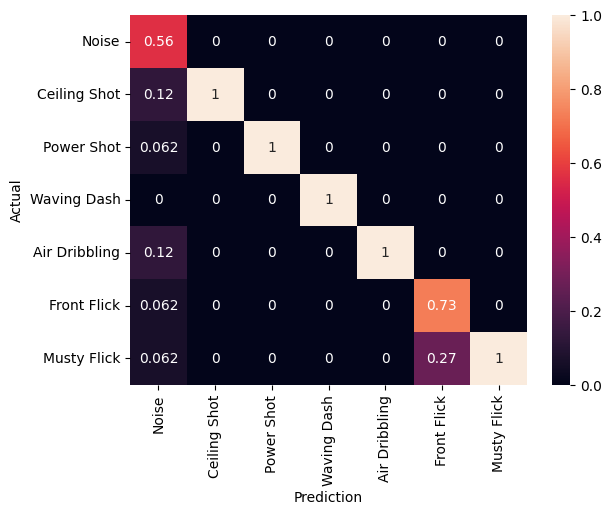

In [53]:
#getting the results
xgb_best_pred = xgb_cv_model.transform(test)
xgb_best_pred.select("prediction", 'class').show(15)
print_metrics(xgb_best_pred)

As we can see we, we achieved almost identical performances as the default model. Thus another round of optimization was attempted (other than testing the other parameters previously listed).
This time, the parameters explored were:
- Lambda regularization term (L2): in {0, 0.1, 0.5};
- Alpha regularization term (L1): in {0, 0.1, 0.3};
- Gamma (Minimum loss delta): in {0.01,0.025, 0.05};
- Minimum sum of weights to proceed with splitting: between 1 and 1.1

Other parameters were fixed instead, by looking which values in the previous tuning round more likely would bring good results:
- <code>max_depth</code> = 8;
- <code>learning_rate</code> = 0.1;
- <code>num_estimators</code> = 200;

Other than these values, other combinations were tested, as also trying to use less boosting rounds, but also here they did not improve the model.

In [39]:
# base model
xgb_cv2 = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         verbose=0,
                         random_state=seed)
# building the grid
xgb_param_grid2 = ParamGridBuilder()\
                .baseOn({xgb_cv2.n_estimators:200, xgb_cv2.learning_rate:0.1, xgb_cv2.max_depth: 8})\
                .addGrid(xgb_cv2.reg_lambda, [0, 0.1, 0.5 ])\
                .addGrid(xgb_cv2.reg_alpha, [0, 0.1, 0.3])\
                .addGrid(xgb_cv2.gamma, [0.01, 0.025, 0.05])\
                .addGrid(xgb_cv2.min_child_weight, [1, 1.1]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val2 = CrossValidator(estimator=xgb_cv2,
                              estimatorParamMaps=xgb_param_grid2,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model2 = xgb_cross_val2.fit(train)

Here we save the model and plot the best hyperparameters found...

In [53]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model2.getEstimatorParamMaps()[np.argmax(xgb_cv_model2.avgMetrics)].items()})

Best parameters:
{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'gamma': 0.05, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1}


In [9]:
xgb_cv_model2.save(path+"models/xgb/hyperParameterTuned2")

23/09/19 21:56:33 WARN TaskSetManager: Stage 80362 contains a task of very large size (1643 KiB). The maximum recommended task size is 1000 KiB.


...And the results.

2023-09-27 23:58:14,243 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows



2023-09-27 23:58:15,082 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-27 23:58:15,196 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


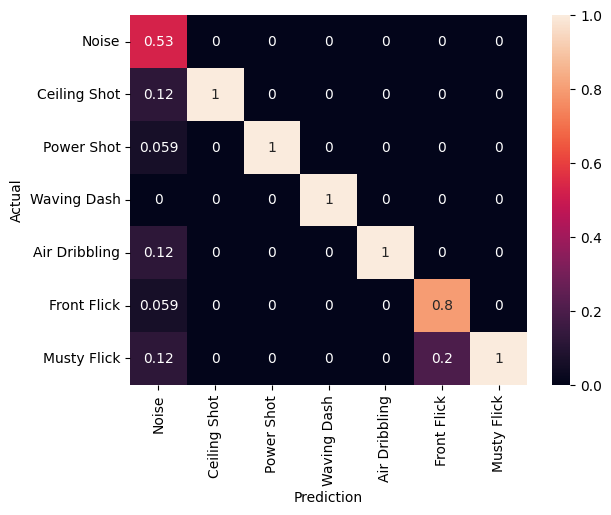

In [52]:
xgb_best_pred2 = xgb_cv_model2.transform(test)
xgb_best_pred2.select("prediction", 'class').show(15)
print_metrics(xgb_best_pred2)

# COMMENTI RISULTATI

## SVM
SVM is the only model we apply the One-vs-Rest technique as PySpark offers only the LinearSVC as Support Vector Machine, which is a binary classifier.

In [21]:
svm = OneVsRest(classifier=LinearSVC(), featuresCol='features', labelCol='class', parallelism=2)
# fitting the model
svmf = svm.fit(train)
# saving
svmf.save(model_path+"svm/base")

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       6.0|
|    5|       5.0|
|    5|       0.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       4.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

Accuracy: 
0.767
Weighted precision: 
0.815
Weighted recall: 
0.767


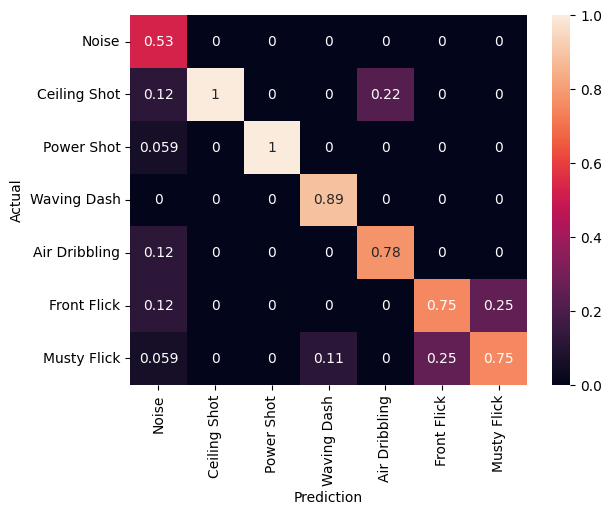

In [55]:
# getting the results
svm_predictions = svmf.transform(test)
svm_predictions.select('class', 'prediction').show(15)
print_metrics(svm_predictions)

In order to tune the LinearSVC, we choose the following hyperparameters:
- Maximum number of iterations: in {50, 100, 500};
- Regularization parameter: in {0.001, 0.01, 0.1, 1.0, 10, 100, 1000};
- Whether to fit an intercept term: True or False;
- Cpnvergence tolerance: in {1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6}.

In [7]:
# base model
svm_base = LinearSVC()
svm_cv = OneVsRest(classifier=svm_base,featuresCol='features', labelCol='class')

# building the grid
svm_param_grid = ParamGridBuilder()\
    .addGrid(svm_base.maxIter, [50,100,500 ])\
    .addGrid(svm_base.regParam, [0.001, 0.01, 0.1, 1.0, 10, 100, 1000])\
    .addGrid(svm_base.fitIntercept, [True, False])\
    .addGrid(svm_base.tol, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
svm_cross_val = CrossValidator(estimator=svm_cv,
                              estimatorParamMaps=svm_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
svm_cv_model = svm_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [59]:
print("Best parameters:")
print({k.name : v for (k,v) in svm_cv_model.getEstimatorParamMaps()[np.argmax(svm_cv_model.avgMetrics)].items()})
svm_cv_model.save(model_path+"svm/hyperParameterTuned")

Best parameters:
{'fitIntercept': True, 'regParam': 0.1, 'tol': 0.01, 'maxIter': 50}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       0.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.817
Weighted precision: 
0.859
Weighted recall: 
0.817


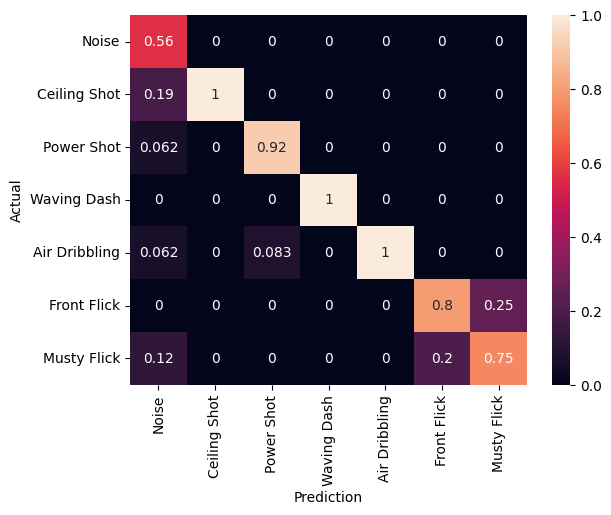

In [56]:
svm_best_pred = svm_cv_model.transform(test)
svm_best_pred.select("prediction", 'class').show(15)
print_metrics(svm_best_pred)

# COMMENTARE RISULTATI

## Naive Bayes

In [12]:
nb = NaiveBayes(featuresCol='features', labelCol='class', smoothing=1e-9,
               modelType='gaussian')
# fitting the model
nbf = nb.fit(train)
# saving
nbf.save(model_path+"nb/base")


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       2.0|
|    5|       6.0|
|    5|       5.0|
|    5|       5.0|
|    6|       6.0|
|    6|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

Accuracy: 
0.667
Weighted precision: 
0.742
Weighted recall: 
0.667


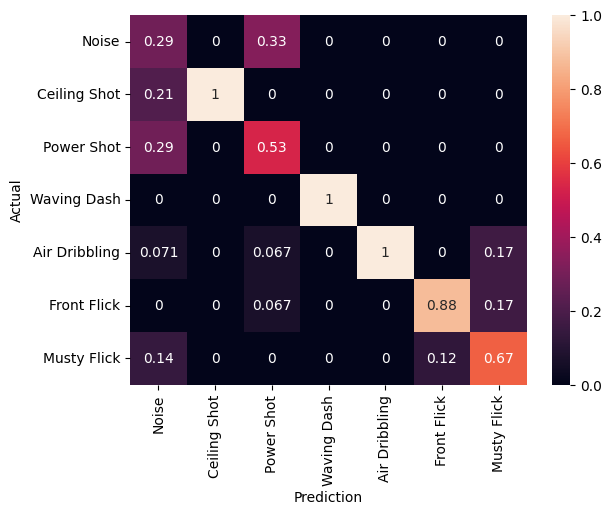

In [57]:
# getting the predictions
nb_predictions = nbf.transform(test)
nb_predictions.select('class', 'prediction').show(15)
print_metrics(nb_predictions)

The hyperparameter space of the Naive Bayes classifier is quite narrow, as it has only two parameters that can be reasonably tuned:
- Label smoothing: in {1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9};
- Type of the model: between multinomial, gaussian or bernoulli.

In [17]:
# base model
nb_cv = NaiveBayes(featuresCol='features', labelCol='class')

# building the grid
nb_param_grid = ParamGridBuilder()\
    .addGrid(nb_cv.smoothing, [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9])\
    .addGrid(nb_cv.modelType, ['multinomial','gaussian', 'bernoulli']).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

nb_cross_val = CrossValidator(estimator=nb_cv,
                              estimatorParamMaps=nb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

In [ ]:
nb_cv_model = nb_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [63]:
print("Best parameters:")
print({k.name : v for (k,v) in nb_cv_model.getEstimatorParamMaps()[np.argmax(nb_cv_model.avgMetrics)].items()})
nb_cv_model.save(path+"models/nb/hyperParameterTuned")

Best parameters:
{'modelType': 'bernoulli', 'smoothing': 0.01}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
+----------+-----+
only showing top 5 rows

Accuracy: 
0.783
Weighted precision: 
0.820
Weighted recall: 
0.783


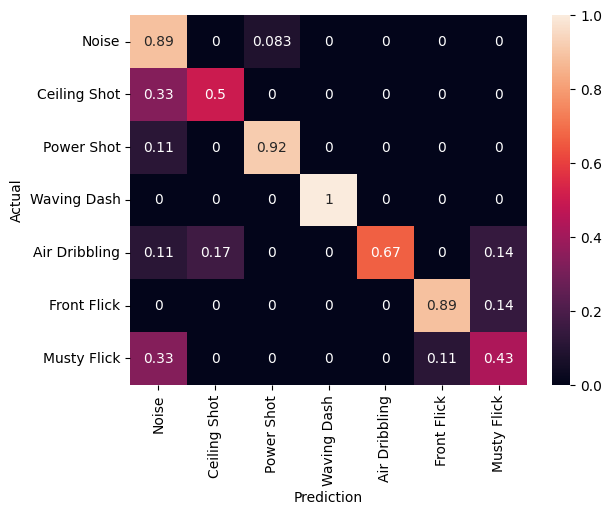

In [64]:
nb_best_pred = nb_cv_model.transform(test)
nb_best_pred.select("prediction", 'class').show(15)
print_metrics(nb_best_pred)

# COMMENTARE RISULTATI

## Summary of the results and final comments
Before presenting the summarization of the results, we add two cells: one to generate the predictions in case the models have been loaded and the other to generate the metrics to be displayed

In [10]:
# generate predictions if the models have been loaded
dtc_predictions = dtcf.transform(test)
rfc_predictions = rfcf.transform(test)
xgb_predictions = xgbf.transform(test)
svm_predictions = svmf.transform(test)
nb_predictions = nbf.transform(test)

dtc_best_pred = dtc_cv_model.transform(test)
rfc_best_pred = rfc_cv_model.transform(test)
xgb_best_pred = xgb_cv_model.transform(test)
svm_best_pred = svm_cv_model.transform(test)
nb_best_pred = nb_cv_model.transform(test)

In [ ]:
# generate metrics
dtc_metrics = compute_metrics(dtc_predictions)
rfc_metrics = compute_metrics(rfc_predictions)
xgb_metrics = compute_metrics(xgb_predictions)
svm_metrics = compute_metrics(svm_predictions)
nb_metrics = compute_metrics(nb_predictions)

dtc_best_metrics = compute_metrics(dtc_best_pred)
rfc_best_metrics = compute_metrics(rfc_best_pred)
xgb_best_metrics = compute_metrics(xgb_best_pred)
svm_best_metrics = compute_metrics(svm_best_pred)
nb_best_metrics = compute_metrics(nb_best_pred)

In [ ]:
We then plot summarizing 

In [29]:
model_names = ['DT', 'RF', 'XGB', 'SVM', 'NB']
final_metrics = [dtc_metrics, rfc_metrics, xgb_metrics, svm_metrics, nb_metrics]
improved_metrics = [dtc_best_metrics, rfc_best_metrics, xgb_best_metrics, svm_best_metrics, nb_best_metrics]
# width is used to control the width of the bars in the following plots
width=0.25

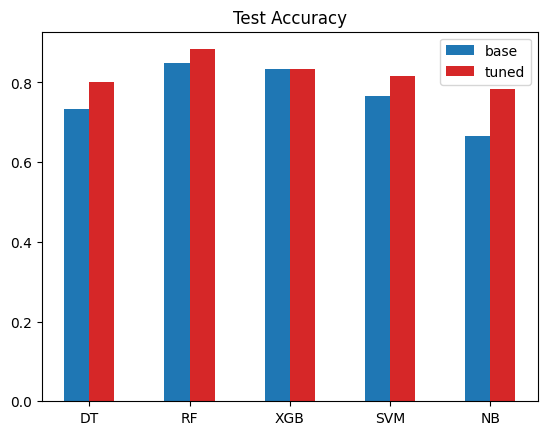

In [101]:
plt.title("Test Accuracy")
# plotting final accuracy in blue
plt.bar(np.arange(len(model_names)),
        [i.accuracy for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
# plotting improved accuracy in red
plt.bar(np.arange(len(model_names))+width,
        [i.accuracy for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

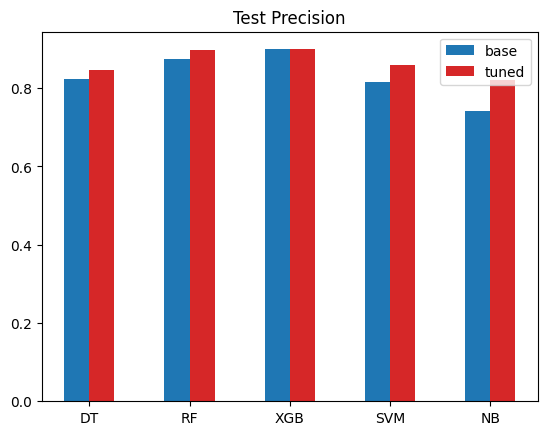

In [100]:
plt.title("Test Precision")
# plotting final precision in blue
plt.bar(np.arange(len(model_names)),
        [i.weightedPrecision for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
# plotting improved precision in red
plt.bar(np.arange(len(model_names))+width,
        [i.weightedPrecision for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

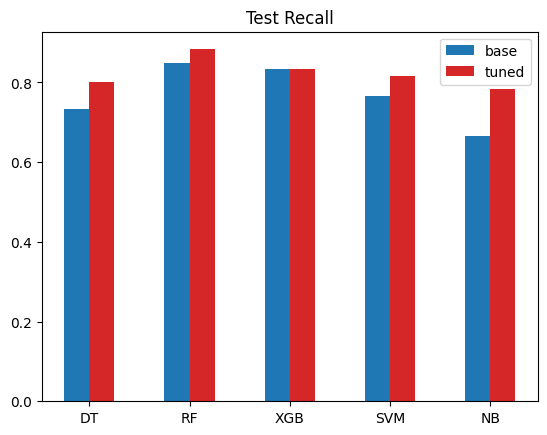

In [99]:
plt.title("Test Recall")
# plotting final recall in blue
plt.bar(np.arange(len(model_names)),
        [i.weightedRecall for i in final_metrics],
        color='tab:blue', label="base",
       width=width)
# plotting improved recall in red
plt.bar(np.arange(len(model_names))+width,
        [i.weightedRecall for i in improved_metrics],
        color='tab:red', label='tuned',
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()